# Tangles-CNN Training Notebook

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import json
from PIL import Image

# Import modified wildcat
sys.path.append("wildcat.pytorch")
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat_gmm import *

# Print basic stats
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
CUDA status:  True
CUDA memory max alloc:        0 MB


## Model Setup
Modify data location and parameters below to your specifications

In [2]:
# Top level data directory. Replace with the directory containing the output of organize_samples.sh 
# The directory must conform to the PyTorch ImageFolder structure
exp_dir = "/home/pyushkevich/data/thon2019_reorg/exp02_multiclass"

# Create a config object - this gets saved along with the model after training
# Please see Durand CVPR 2018 (WildCat paper) for meaning of kmin, kmax, alpha, num_maps
config = {
    "num_classes": 4,
    "wildcat_upsample": {
        "kmax": 0.02,
        "kmin": 0.0,
        "alpha": 0.7,
        "num_maps": 4,
        "input_size": 224,
        "num_epochs": 30,
        "batch_size": 8
    }
}

## Model instantiation and training

In [3]:
# Instantiate WildCat model
data_dir = os.path.join(exp_dir, "patches")
# data_dir = '/home/pyushkevich/data/thon2019/exp01/fold_HNL-11-15'

model = UNet_WSL_GMM(
    num_classes = config['num_classes'],
    mix_per_class=config['wildcat_upsample']['num_maps'], 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'])

In [4]:
# Loss and optimizer
# criterion = nn.MultiLabelSoftMarginLoss()

# We use BCE loss because network outputs are probabilities, and this loss
# does log clamping to prevent infinity or NaN in the gradients
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)

# Transforms for training and validation
input_size = config['wildcat_upsample']['input_size']
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Training and validation dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=config['wildcat_upsample']['batch_size'], 
                                                   shuffle=True, 
                                                   num_workers=4) for x in ['train', 'val']}

tensor([3, 2, 0, 0, 0, 0, 2, 0])

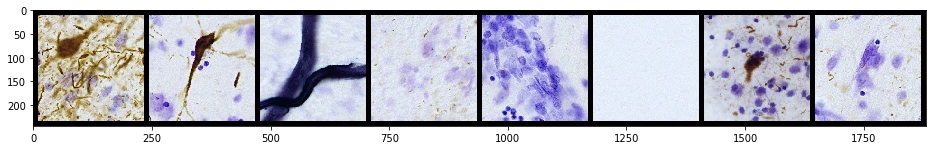

In [5]:
# Read a batch of data from the training data loader
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
img,label=next(iter(dataloaders_dict['train']))
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))
label

In [6]:
# Load previous model?

In [7]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:0


In [8]:
# Try the model on one minibatch
with torch.set_grad_enabled(False):
    x = img.to(device)
    z = model(x)

z

tensor([[0.2329, 0.3125, 0.2574, 0.1973],
        [0.2289, 0.3268, 0.2335, 0.2108],
        [0.2100, 0.3253, 0.2667, 0.1980],
        [0.2361, 0.2956, 0.2194, 0.2489],
        [0.2359, 0.3021, 0.2281, 0.2340],
        [0.2765, 0.2902, 0.2232, 0.2101],
        [0.2436, 0.3292, 0.2318, 0.1954],
        [0.2620, 0.2732, 0.2045, 0.2604]], device='cuda:0')

In [22]:
# Define the criterion suitable for probabilities (which is what the model outputs)
# def wsl_gmm_criterion(z, labels_one_hot):
#    return torch.mean(- (torch.log(z) * labels_one_hot + torch.log(1-z) * (1-labels_one_hot)))
#
#class WSL_GMM_Loss():
#        
#    def forward(self, z, labels_one_hot):
#        return wsl_gmm_criterion(z, labels_one_hot)
#    
#criterion = wsl_gmm_criterion

In [23]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            mb = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], config['num_classes']])
                for k in range(config['num_classes']):
                    labels_one_hot[:,k] = (labels==k)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels_one_hot)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Print minimatch stats
                mb = mb + 1
                print('MB %04d  loss %f  corr %d' %
                      (mb, loss.item(), torch.sum(preds == labels.data).item()))
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
            # Save a copy of the model
            torch.save(model.state_dict(), '/tmp/checkpt_multi_%03d.pt' % (epoch,))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [24]:
# Train and evaluate
# model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=config['wildcat_upsample']['num_epochs'])
# model.load_state_dict(torch.load('/tmp/checkpt_fc_013.pt'))
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
MB 0001  loss 0.521082  corr 3
MB 0002  loss 0.530156  corr 2
MB 0003  loss 0.579704  corr 2
MB 0004  loss 0.547817  corr 3
MB 0005  loss 0.560274  corr 3
MB 0006  loss 0.479774  corr 6
MB 0007  loss 0.502107  corr 5
MB 0008  loss 0.547215  corr 4
MB 0009  loss 0.492968  corr 7
MB 0010  loss 0.499104  corr 5
MB 0011  loss 0.569547  corr 3
MB 0012  loss 0.554414  corr 2
MB 0013  loss 0.517735  corr 4
MB 0014  loss 0.561213  corr 2
MB 0015  loss 0.490986  corr 5
MB 0016  loss 0.553242  corr 3
MB 0017  loss 0.532829  corr 3
MB 0018  loss 0.493584  corr 5
MB 0019  loss 0.508824  corr 4
MB 0020  loss 0.529084  corr 3
MB 0021  loss 0.512122  corr 5
MB 0022  loss 0.519420  corr 3
MB 0023  loss 0.499819  corr 4
MB 0024  loss 0.515475  corr 3
MB 0025  loss 0.533498  corr 2
MB 0026  loss 0.505869  corr 5
MB 0027  loss 0.511628  corr 4
MB 0028  loss 0.556674  corr 3
MB 0029  loss 0.452776  corr 6
MB 0030  loss 0.515166  corr 4
MB 0031  loss 0.512678  corr 4
MB 0032  loss 0.59

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 151, in __getitem__
    sample = self.loader(path)
  File "/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 188, in default_loader
    return pil_loader(path)
  File "/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 168, in pil_loader
    with open(path, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/pyushkevich/data/thon2019_reorg/exp02_multiclass/patches/train/background/9763.png'


In [10]:
# Load previous model?
# model.load_state_dict(torch.load('/tmp/checkpt_fc_013.pt'))
model.load_state_dict(torch.load('/home/pyushkevich/data/thon2019_reorg/exp02_multiclass/models/wildcat_upsample.dat'))

<All keys matched successfully>

In [76]:
img,label=next(iter(dataloaders_dict['val']))
x = img.to(device)

labels_one_hot = torch.zeros([label.shape[0], config['num_classes']])
for k in range(config['num_classes']):
    labels_one_hot[:,k] = (label==k)
labels_one_hot = labels_one_hot.to(device)

with torch.set_grad_enabled(False):
    y=model.softmax(model.unet(x))
    z=y
    for g in model.gmm: 
        z = g(z,x)
        
    # Apply spatial pooling to the probabilities (take average of max-values)
    z1 = model.spatial_pooling(z)
        
    # Apply the linear transformation to mix probabilities for classification
    z2 = model.fc_pooled(z1)
    sp = model.softmax_pooled(z2)
    
    cp = torch.softmax((torch.matmul(z.permute(0,2,3,1), model.fc_pooled.weight.permute(1,0)) + model.fc_pooled.bias.view(1,1,1,-1)).permute(0,3,1,2),1)
    # cp = model.classwise_pooling(z) * config['wildcat_upsample']['num_maps']
    
    # cp = model.classwise_pooling(z) * 4
    # sp = model.spatial_pooling(cp)
    
_, preds = torch.max(sp, 1)
criterion(sp, labels_one_hot).item(), sum(preds.cpu() == label).item()

(0.32997584342956543, 8)

In [77]:
sp, criterion(sp, labels_one_hot).item(), sum(preds.cpu() == label).item()

(tensor([[0.0549, 0.1349, 0.6872, 0.1230],
         [0.4430, 0.2890, 0.1228, 0.1453],
         [0.0851, 0.2153, 0.4734, 0.2261],
         [0.4476, 0.2836, 0.1163, 0.1525],
         [0.1238, 0.2238, 0.4643, 0.1881],
         [0.1838, 0.2121, 0.1538, 0.4503],
         [0.4294, 0.2981, 0.1157, 0.1567],
         [0.4586, 0.2681, 0.1162, 0.1571]], device='cuda:0'),
 0.32997584342956543,
 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


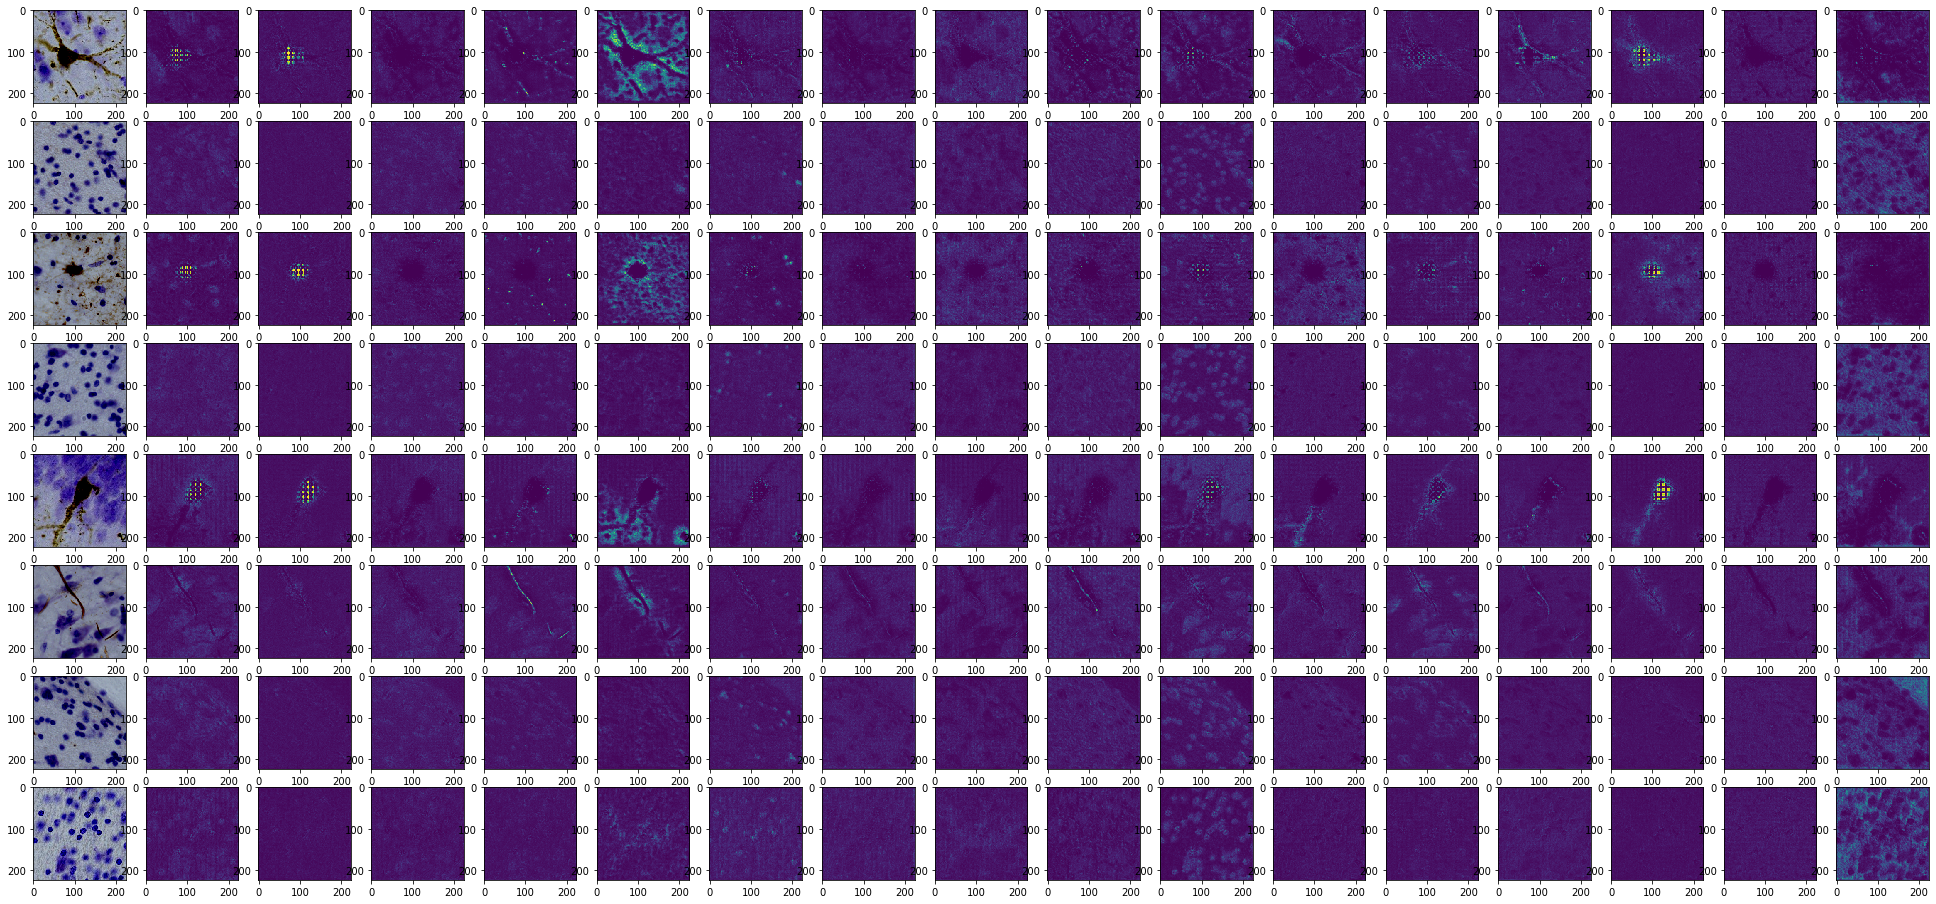

In [78]:
# Batches/channels to show
nnb = np.min([8, z.shape[0]])
nnc = np.min([16, z.shape[1]])

plt.figure(figsize=((1+nnc) * 2, nnb * 2))
for b in range(nnb):
    plt.subplot(nnb, (1+nnc), (1+nnc)*b + 1)
    plt.imshow(x[b,:,:,:].permute(1,2,0).detach().cpu().numpy() * 0.3)
    for k in range(nnc):
        plt.subplot(nnb, (1+nnc), (1+nnc)*b + k + 2)
        plt.imshow(y[b,k,:,:].detach().cpu().numpy(), vmin=0, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


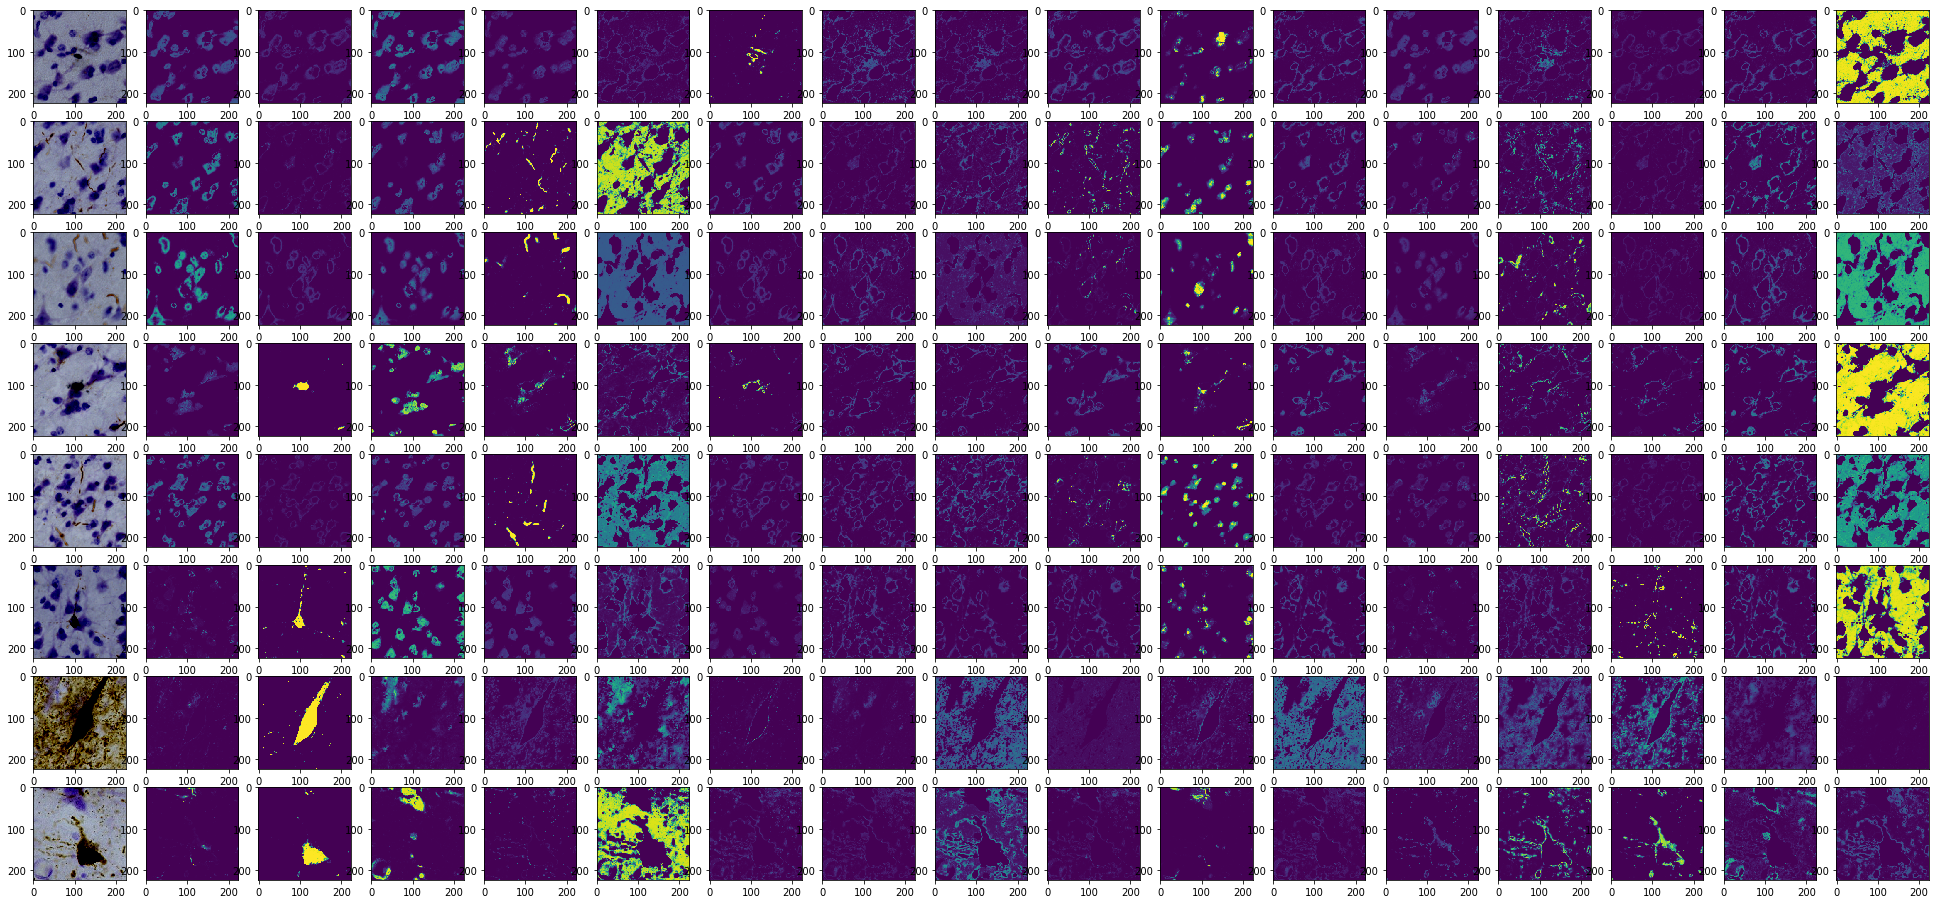

In [58]:
plt.figure(figsize=((1+nnc) * 2, nnb * 2))
for b in range(nnb):
    plt.subplot(nnb, (1+nnc), (1+nnc)*b + 1)
    plt.imshow(x[b,:,:,:].permute(1,2,0).detach().cpu().numpy() * 0.3)
    for k in range(nnc):
        plt.subplot(nnb, (1+nnc), (1+nnc)*b + k + 2)
        plt.imshow(z[b,k,:,:].detach().cpu().numpy(), vmin=0, vmax=1)

In [59]:
nnb,nnc

(8, 16)

In [60]:
model.fc_pooled.weight.shape, model.fc_pooled.bias.shape, z.shape

(torch.Size([4, 16]), torch.Size([4]), torch.Size([8, 16, 224, 224]))

In [62]:
for a,b in enumerate(model.fc_pooled.named_parameters()):
    print(a,b)

0 ('weight', Parameter containing:
tensor([[-0.2376, -0.4053,  0.0271, -0.2587, -0.3009,  0.0849,  0.1455, -0.2356,
          0.3134,  0.3440, -0.1302,  0.0234, -0.4229, -0.4219,  0.0141,  0.4053],
        [-0.1261, -0.0869,  0.0690,  0.1246, -0.0690,  0.0828,  0.0448,  0.1207,
          0.0075, -0.1582,  0.1891,  0.2498, -0.2665,  0.0873, -0.0345,  0.3040],
        [-0.2208,  0.5975,  0.4720, -0.4115,  0.3723, -0.1858, -0.1159,  0.0406,
         -0.1423, -0.3087, -0.0483,  0.2392,  0.4297,  0.5919,  0.3145, -0.3533],
        [ 0.4341, -0.4613, -0.3340,  0.7543,  0.4033, -0.1004,  0.1243,  0.0910,
          0.0391,  0.0100, -0.0850, -0.0744,  0.2823, -0.1056,  0.1604, -0.3798]],
       device='cuda:0', requires_grad=True))
1 ('bias', Parameter containing:
tensor([ 0.3294,  0.0546, -0.2145, -0.1828], device='cuda:0',
       requires_grad=True))


In [71]:
(cp[2,2,:,:] - torch.sum(cp[2,:,:,:], dim=0, keepdim=True)).shape

torch.Size([1, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


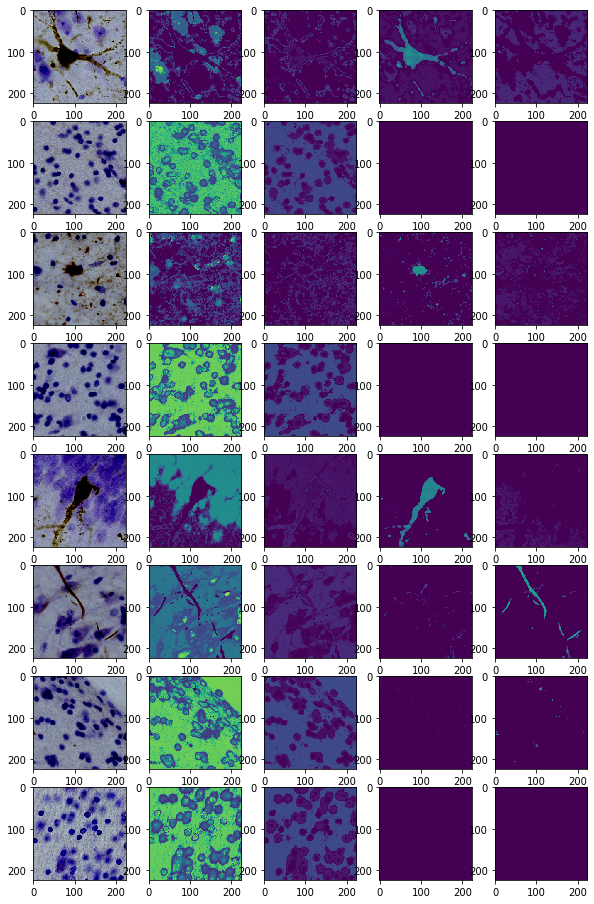

In [79]:
nnk = cp.shape[1]
plt.figure(figsize=((1+nnk) * 2, nnb * 2))
for b in range(nnb):
    plt.subplot(nnb, (1+nnk), (1+nnk)*b + 1)
    plt.imshow(x[b,:,:,:].permute(1,2,0).detach().cpu().numpy() * 0.3)
    for k in range(nnk):
        plt.subplot(nnb, (1+nnk), (1+nnk)*b + k + 2)
        plt.imshow(cp[b,k,:,:].squeeze().detach().cpu().numpy(), vmin=0.25, vmax=0.5)

In [78]:
model.spatial_pooling

WildcatPool2d (kmax=0.02, kmin=0.0, alpha=0.7)

## Export model

In [18]:
# Save the model using a format that can be read using production-time scripts
model_dir = os.path.join(exp_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model_ft.state_dict(), os.path.join(model_dir, "wildcat_upsample.dat"))

# Save the configuration
with open(os.path.join(model_dir, 'config.json'), 'w') as jfile:
    json.dump(config, jfile)

Model performance over epochs

In [34]:
plt.plot(hist)

NameError: name 'hist' is not defined

In [12]:
del model_ft
torch.cuda.empty_cache()

In [13]:
!nvidia-smi

Mon Dec 14 16:12:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    49W / 250W |   2079MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------